In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [41]:
# Load the telemetry data
data_path = "../data/processed_data/telemetry_data.csv"
df = pd.read_csv(data_path)


In [42]:
# Timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [51]:
# Drop non-numeric columns (timestamp, respondent)
df_numeric = df.drop(columns=["timestamp", "respondent"])

In [52]:
# Sort data by timestamp
df = df.sort_values("timestamp")

In [53]:
# Calculate the time range in hours
time_range_hours = (df["timestamp"].max() - df["timestamp"].min()).total_seconds() / 3600

# Set the locator based on the time range
if time_range_hours <= 24:
    locator = mdates.HourLocator(interval=1)
elif time_range_hours <= 72:
    locator = mdates.HourLocator(interval=3)
elif time_range_hours <= 168:
    locator = mdates.HourLocator(interval=6)
else:
    locator = mdates.DayLocator(interval=1)

In [54]:
# Nomalize the data uing StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

In [55]:
# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_predictions = iso_forest.fit_predict(scaled_data)

print("Anomaly predictions (should be 1 for normal, -1 for anomalies):")
print(anomaly_predictions)

df["anomaly"] = anomaly_predictions

Anomaly predictions (should be 1 for normal, -1 for anomalies):
[-1  1  1 ... -1 -1 -1]


In [56]:
# Mark anomalies (1 = normal, -1 = anomaly)
if "anomaly" in df.columns:
    df["anomaly"] = df["anomaly"].map({1: "Normal", -1: "Anomaly"})
    print("Anomaly column mapped:")
    print(df[["timestamp", "anomaly"]].head())
else:
    print("Anomaly column not found in, check IsolationForest output.")

Anomaly column mapped:
               timestamp  anomaly
1247 2024-11-08 23:00:00  Anomaly
1246 2024-11-09 00:00:00   Normal
1245 2024-11-09 01:00:00   Normal
1244 2024-11-09 02:00:00   Normal
1243 2024-11-09 03:00:00   Normal


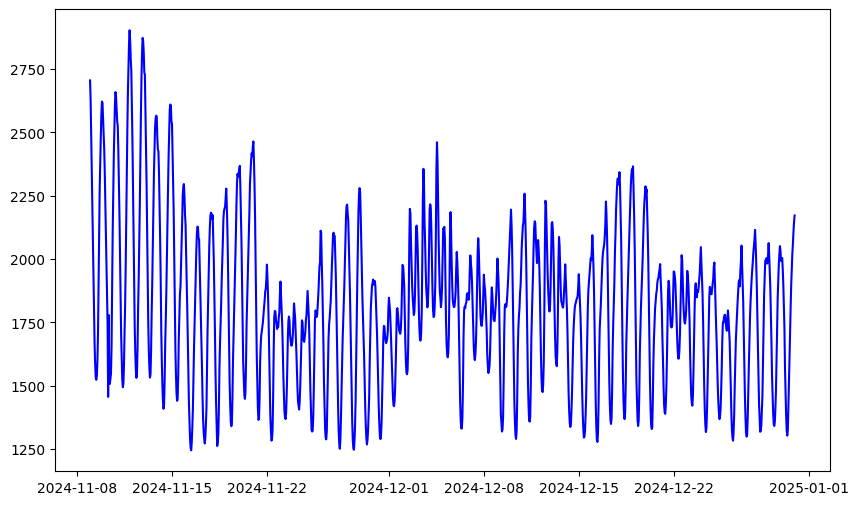

In [57]:
# Plot data
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["demand_mw"], label="Demand MW", color="blue")

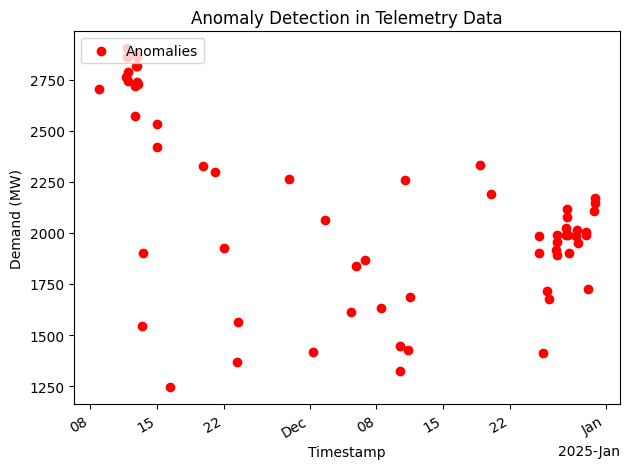

Anomalies detected and saved.


In [64]:
# Plotting the demand_mw against time
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate()

# Hightlight anomalies
df_anomalies = df[df["anomaly"] == "Anomaly"]
if not df_anomalies.empty:
    plt.scatter(df_anomalies["timestamp"], df_anomalies["demand_mw"], color="red", label="Anomalies", zorder=5)

plt.xlabel("Timestamp")
plt.ylabel("Demand (MW)")
plt.title("Anomaly Detection in Telemetry Data")
plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

df.to_csv("../data/processed_data/telemetry_with_anomalies.csv", index=False)
print("Anomalies detected and saved.")